# Imports

In [1]:
# To install OpenCV: type "conda install opencv" on terminal 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import glob

from skimage.feature import corner_harris, corner_peaks
import cv2

if not os.path.exists("Q1"):
    os.makedirs("Q1")

# 1.1 - Viewing Images as Movies

In [2]:
def animate_tool(frames, interval, repeat, repeat_delay):
    fig = plt.figure()
    im = plt.imshow(frames[0], cmap=plt.get_cmap('gray'), vmin=0, vmax=255, animated=True)
    
    def updatefig(j):
        im.set_array(frames[j])
        return im,

    ani = animation.FuncAnimation(fig, updatefig, frames=range(len(frames)), blit=True,
                                  interval=interval, repeat=repeat, repeat_delay=repeat_delay)
    return ani

/Users/chongyeegan/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


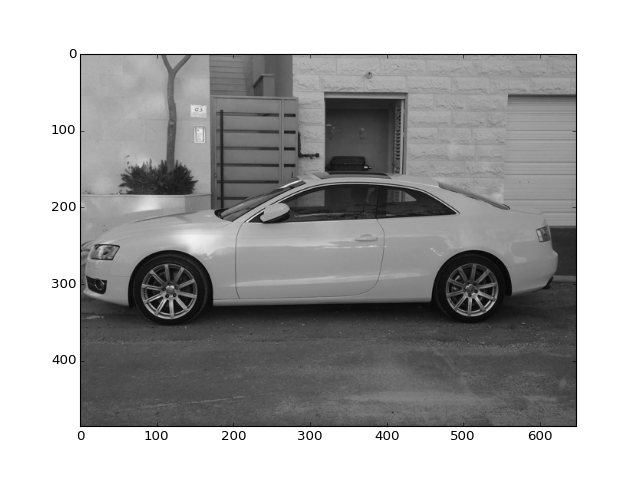

In [3]:
%matplotlib notebook
if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []
    
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = plt.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))

    #print imagelist
    frames = [i[1] for i in imagelist]
    #print frames
    
    # kick off the animation
    ani = animate_tool(frames, 100, True, 500)

    mins = []

# 1.2 - Harris Corner Detector 

In [109]:
%matplotlib inline

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))
    
    #OpenCV Method    
    for filename, frame in imagelist:
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        #dst = cv2.cornerHarris(gray,2,3,0.04)
        #img[dst>0.01*dst.max()]=[0,0,255]
        #cv2.imshow('dst',img)
        corners = cv2.goodFeaturesToTrack(gray, 100, 0.01, 10)
        corners = np.int0(corners)

        for i in corners:
            x,y = i.ravel()
            cv2.circle(frame,(x,y),3,255,-1)

        plt.imshow(frame)
        fn = filename + '_corner.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()

        
    ''''
    #Skimage Method
    for filename, frame in imagelist:    
        ch = corner_harris(frame, k=0.04)
        coords = corner_peaks(ch, 1, 0)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))

        ax.imshow(frame, interpolation='nearest', cmap=plt.cm.gray)
        ax.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
        plt.axis('off')
        fn = filename + '_corner.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()
    '''
      


# 1.3 - Manual Matching

In [119]:
%matplotlib inline

if __name__ == '__main__':
    path = 'Images/Q1'
    imagelist = []

    # reading images and storing filename
    for filename in glob.glob(os.path.join(path, '*.bmp')): 
        im = cv2.imread(filename)
        fn = filename.split('/')[-1].split('.')[0]
        imagelist.append((fn, im))
    
    #List of feature points. Each row represents an image's 7 feature points respectively. 7 rows (image) in total
    FP = []
    
    #Drawing Select Feature Points for All Images   
    for filename, frame in imagelist:
        #initialise array to store current image's feature points
        temp = []
        
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        corners = cv2.goodFeaturesToTrack(gray, 100, 0.615, 8)
        corners = np.int0(corners)
        
        # sorting the corners coordinates
        ind = np.lexsort((corners[:,0,0],corners[:,0,1]))    
        sortedCorners = corners[ind]
        
        # 1st Feature Point (white)
        x,y = sortedCorners[0].ravel()
        cv2.circle(frame,(x,y),3,(255,255,255),-1)
        temp.append((x,y))
        # 2nd Feature Point (black)
        x,y = sortedCorners[1].ravel()
        cv2.circle(frame,(x,y),3,(0,0,0),-1)
        temp.append((x,y))
        # 3rd Feature Point (red)
        x,y = sortedCorners[2].ravel()
        cv2.circle(frame,(x,y),3,(255,0,0),-1)
        temp.append((x,y))
        # 4th Feature Point (green)
        x,y = sortedCorners[3].ravel()
        cv2.circle(frame,(x,y),3,(0,128,0),-1)
        temp.append((x,y))
        # 5th Feature Point (blue)
        x,y = sortedCorners[4].ravel()
        cv2.circle(frame,(x,y),3,(0,0,255),-1)
        temp.append((x,y))
        
        # 6th Feature Point (yellow)
        if filename == "car3" or filename == "car4" or filename == "car5":
            x,y = sortedCorners[6].ravel()
            cv2.circle(frame,(x,y),3,(255,255,0),-1)
            temp.append((x,y))
        else:
            x,y = sortedCorners[5].ravel()
            cv2.circle(frame,(x,y),3,(255,255,0),-1)
            temp.append((x,y))

        # 7th Feature Point (pink)
        if filename == "car1" or filename == "car7":
            x,y = sortedCorners[9].ravel()
            cv2.circle(frame,(x,y),3,(255,105,180),-1)
            temp.append((x,y))
        elif filename == "car6":
            x,y = sortedCorners[8].ravel()
            cv2.circle(frame,(x,y),3,(255,105,180),-1)
            temp.append((x,y))
        else:    
            x,y = sortedCorners[7].ravel()
            cv2.circle(frame,(x,y),3,(255,105,180),-1)
            temp.append((x,y))
        
        # Store this image's feature points to the feature points list
        FP.append(temp)
        
        #saving images
        plt.imshow(frame)
        fn = filename + '_manualMatch.png'
        plt.savefig('Q1/' + fn, dpi=200)
        plt.close()


# 1.4 - Affine Transformation

In [136]:
# Reference - http://stackoverflow.com/questions/20546182/how-to-perform-coordinates-affine-transformation-using-python-part-2
#           - http://docs.scipy.org/doc/scipy/reference/tutorial/linalg.html
#           - http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.lstsq.html

# Create Matrix of Reference Feature Points
refPoint = np.vstack(FP[0][:])
refPoint = np.vstack([refPoint.T, np.ones(len(FP[0]))]).T

# Initialise Affine Transform Parameter List (each row represents an affine transform of ref image to Image[n])
A = []

for i in range(1,len(FP)):
    # Create Matrix of Current Image's Feature Points (Xi and Yi)
    imgPoint = np.vstack([FP[i][:]])
    # Calculating A, where imgPoint = refPoint*A
    A.append(np.linalg.lstsq(refPoint, imgPoint)[0])
    
# Each row in A represents a 3X2 matrix - [[a11,a21],
#                                          [a12,a22],
#                                          [b1,b2]] 

[[ 370.  153.    1.]
 [ 240.  211.    1.]
 [ 489.  213.    1.]
 [ 221.  224.    1.]
 [ 123.  308.    1.]
 [ 519.  320.    1.]
 [ 124.  325.    1.]]


# 1.5 - Stabilization

[[ 1.00053956  0.00141629]
 [-0.0056684   1.00277434]
 [ 0.68812221  0.45420388]]


# 1.6 - Automatic Matching

In [40]:
refPoint = np.hstack([f2[0],1])
refPoint = np.vstack([refPoint, [1,1,1]]).T


for i in range(1,7):
    imgPoint = np.hstack([f2[i],1])
    imgPoint = np.vstack([imgPoint, [1,1,1]]).T
    A, res, rank, s =  np.linalg.lstsq(imgPoint, refPoint)
    print A

-25.8275862069


# 1.7 - RANSAC

# 1.8 - Stabilization II